# Simulating a 2D image and error analysis using Astropy and MCMC

This notebook shows an example on fitting with Sherpa through its [`Astropy`](http://astropy.org) interface. The interface is realized through the [`Saba`](https://github.com/astropy/sherpa) package.

The example is simple but it shows several interesting features of Sherpa and how it can be used seamlessly from `Astropy`.

In this notebook we:
  - simulate a 2D image of an astronomical source with two gaussian components, in Poisson noise regime;
  - fit the simulated data with a model, providing empirical guesses as initial parameter values;
  - calculate the posterior probability distributions of each model parameters using the MCMC Bayesian framework;
  - calculate and visualize diagnostics of the goodness of fit, including:
     - residuals;
     - a detailed graphical representation of all the paramters posterior probability distributions;
     - a detailed graphical representation of the covariance of the parameters;
     - a graphical comparison of the *true* values with the parameters posterior distributions.

## Initialize matplotlib

The following cell sets up `matplotlib`, the plotting package.

First, it makes sure the plots are visualized inside the notebook, which is best suited for a self-contained notebook, especially on the web. If you run the notebook from your own system, then you might choose to run `matplotlib` interactively in a desktop window.

Then, it imports the `matplotlib` module `pyplot`, which we will use in the notebook.

Finally, it sets up some global parameters that all plots will inherit, e.g. the colormap and the origin point for images we will display.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'cubehelix'
plt.rcParams['image.origin'] = 'lower'

## Import necessary dependencies

At the time of this writing (December 2016) one needs to explicitly import a class from `Saba`, but in future versions of `Astropy` one will be able to import the class directly from `Astropy` assuming that `Saba` is installed.

We also import the `Gaussian2D` model from `Astropy`. `Numpy` provides many data structures and methods for numerical processing, while the `corner` package will be used to display the posterior distributions of the model parameters at the end of this notebook.

In [2]:
from saba import SherpaFitter
from astropy.modeling.models import Gaussian2D
import numpy as np
import corner

## Simulate an image in poissonian noise regime

The cell below simulates the image of an astronomical source.

By simulating the image we can compare the results of the fit with the actual values. For clarity and simplicity, the image is fairly simple, however with Sherpa it is possible to fit complex combination of model functions, simultaneuously fitting the background, and possibly including PSF information. The more complex the model, the longer it will take to get a good fit.

We use numpy to define a mesh-grid of image coordinates.

Then we define the source emission as having two Gaussian components with different parameters. Both components have the same center and no eccentricity.

Finally, we create a "perfect" source by evaluating the two models on the mesh-grid and adding them together.

We generate the actual simulated, noisy image by using numpy to draw a random number from poissonian distributions, each with an expectation value equal to the emission of the "perfect" source.

In [19]:
np.random.seed(4) # This way the notebook will produce the same pseudo-random simulation every time is run
x0lo, x0hi = 3000, 4000
x1lo, x1hi = 4000, 4800
dx = 5
x1, x0 = np.mgrid[x1lo:x1hi:dx, x0lo:x0hi:dx]
shape = x0.shape

source_one = Gaussian2D(x_mean=3561, y_mean=4482, amplitude=35, x_stddev=50, y_stddev=50, theta=0)
source_two = Gaussian2D(x_mean=3561, y_mean=4482, amplitude=10, x_stddev=150, y_stddev=150, theta=0)
source = source_one + source_two

mexp = source(x0, x1).reshape(shape)
image = np.random.poisson(mexp)

We use matplotlib to plot the simulated image.

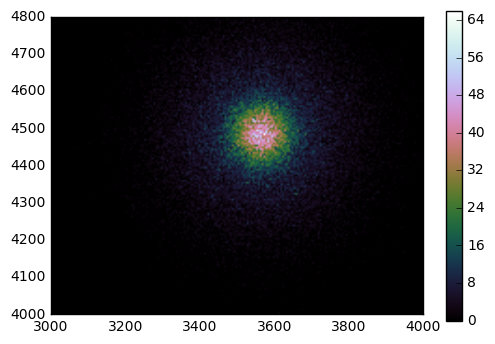

In [20]:
boundaries = (x0lo, x0hi, x1lo, x1hi)
plt.imshow(image, extent=boundaries)
plt.colorbar()

## Fitting the image

We instantiate a fitter object selecting the Cash statistic, the NelderMead optimization algorithm, and the Covariance algorithm for error estimation.

In [5]:
fitter = SherpaFitter(statistic="cash", optimizer="neldermead", estmethod='covariance')

### Guess initial parameters

In order to make the optimization algorithm more effective, we can provide some guesses as the initial parameter values, placing the optimization algorithm in a promising region of the parameter space, as if we didn't know what the actual parameters are, which is usually not the case.

In this particular case, we are going to fit the image with the sum of two Gaussians.

For the amplitude, we are going to *guess* that one component has an amplitude equal to the peak emission of the image, and that the second component's amplitude is one tenth of it. This is all arbitrary, the point being that we are roughly estimating realistic values for the parameters.

For the means, we are going to marginalize one coordinate at a time and then take the coordinates at which the resulting distributions peak. We also assume that the gaussians have the same mean coordinates.

For standard deviations, we don't do anything fancy and we just pick two arbitrary values in a reasonable order of magnitude given the image. Something more data-driven could be done in the same style of what was done for the peak and mean. This is left as an excercise in numpy-fu.

In [6]:
peak = image.max()
ysum = image.sum(axis=0)
xsum = image.sum(axis=1)
xguess = x0[0, np.argmax(ysum)]
yguess = x1[np.argmax(xsum), 0]
stddev_one=100
stddev_two=200

### Setting up the models

Apart from instantiating the models with the initial parameters estimated above, we are going to do two special things. They are not particularly realistic, but they:
  * show how to freeze parameters
  * show how to tie parameters together
  * speed up the demo
  
First, we freeze the `theta` parameter for both components. This parameter will not be varied during the optimization.

Then we link the standard deviations together, assuming the gaussians do not have any eccentricity (note, we know this is true in our simulation, but we usually don't).

In the Astropy modeling framework this is done by providing a linking function that provides the value for a parameter, usually in terms of another parameter of the same model. In this case we simply make the standard deviations in the x and y axis to have the same value in each model.

Also, note how in the composite model the parameters have a `_n` suffix that identifies the parameter as belonging to a specific model.

In [7]:
model_one = Gaussian2D(x_mean=xguess, y_mean=yguess, amplitude=peak, x_stddev=stddev_one, y_stddev=stddev_one)
model_two = Gaussian2D(x_mean=xguess, y_mean=yguess, amplitude=peak/10, x_stddev=stddev_two, y_stddev=stddev_two)

model = model_one + model_two

model.theta_0.fixed = True
model.theta_1.fixed = True

model.x_stddev_0.tied = lambda model: model.y_stddev_0
model.x_stddev_1.tied = lambda model: model.y_stddev_1

## Fit!

In order to fit, we need to pass the x, y, and image arrays as flatt numpy arrays. Then we can simply call the fitter object with the initial model and the x, y, and z arrays.

We also calculate the residuals by computing the model over the same image coordinates.

In [8]:
x = x0.flatten()
y = x1.flatten()
z = image.flatten()

model = fitter(model, x=x, y=y, z=z)

residuals = image - model(x0, x1).reshape(shape)

## Plotting

We can easily use matplotlib to create a composite view of the image, the model, and the residuals

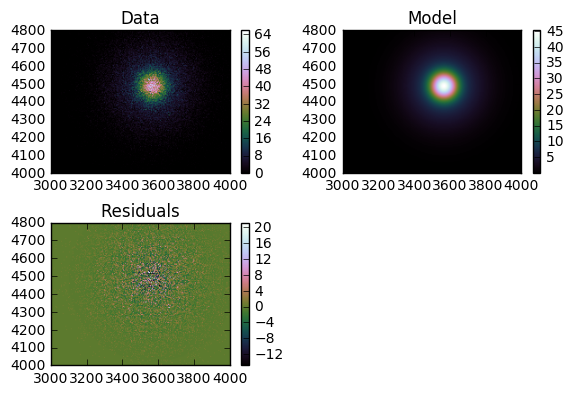

In [9]:
plt.subplot(2, 2, 1)
plt.imshow(image, extent=boundaries)
plt.colorbar()
plt.title('Data')

plt.subplot(2, 2, 2)
plt.imshow(model(x0, x1).reshape(shape), extent=boundaries)
plt.colorbar()
plt.title('Model')

plt.subplot(2, 2, 3)
plt.imshow(residuals, extent=boundaries)
plt.colorbar()
plt.title('Residuals')

plt.tight_layout()

As a rough and quick estimate of the goodness of fit we can check whether the sum of the residuals is close to zero.

In [10]:
residuals.sum()

4.1103283940913116e-06

## Parameter estimates with MCMC

We now use a Markov Chain Monte Carlo algorithm to estimate the posterior probability distribution of the free model parameters.

In [11]:
sampler = fitter.get_sampler()
stats, accept, params = sampler(niter=10000)

Using Priors:
wrap_.amplitude_0: <function flat at 0x7fba85691158>
wrap_.x_mean_0: <function flat at 0x7fba85691158>
wrap_.y_mean_0: <function flat at 0x7fba85691158>
wrap_.y_stddev_0: <function flat at 0x7fba85691158>
wrap_.amplitude_1: <function flat at 0x7fba85691158>
wrap_.x_mean_1: <function flat at 0x7fba85691158>
wrap_.y_mean_1: <function flat at 0x7fba85691158>
wrap_.y_stddev_1: <function flat at 0x7fba85691158>


To make sure we are comparing apples to apples, let's print the model we started with as *true* with the best fit model. We just need to check that the 0 and 1 components have not been switched. This way we can simply rely on the correspondence of the model parameter names in the following cells.

In [18]:
print(source, "\n\n", model)

Model: CompoundModel0
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian2D(amplitude=35.0, x_mean=3561.0, y_mean=4482.0, x_stddev=50.0, y_stddev=50.0, theta=0.0)>

    [1]: <Gaussian2D(amplitude=10.0, x_mean=3561.0, y_mean=4482.0, x_stddev=150.0, y_stddev=150.0, theta=0.0)>
Parameters:
    amplitude_0 x_mean_0 y_mean_0 x_stddev_0 ... x_stddev_1 y_stddev_1 theta_1
    ----------- -------- -------- ---------- ... ---------- ---------- -------
           35.0   3561.0   4482.0       50.0 ...      150.0      150.0     0.0 

 Model: CompoundModel1
Name: 
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian2D(amplitude=66.0, x_mean=3575.0, y_mean=4480.0, x_stddev=100.0, y_stddev=100.0, theta=0.0)>

    [1]: <Gaussian2D(amplitude=6.6, x_mean=3575.0, y_mean=4480.0, x_stddev=200.0, y_stddev=200.0, theta=0.0)>
Parameters:
     amplitude_0     x_mean_0      y_mean_0   ...   y_stddev_1  th

The *burnin* parameter could be set to something different than 0 to take into account an MCMC burn-in time. However, since we started the MCMC with values coming from a fit, we are going to assume no burn-in is required.

Also, in order to produce the representation at the end of this notebook, we need to build an array with the parameter names and an array with the distributions corresponding to those values.

In [ ]:
burnin = 0
parnames = [p.name for p in [getattr(model, name) for name in model.param_names] if not (p.fixed or p.tied)]
parvals = [getattr(source, name).value for name in parnames]

Finally, here is a graphical representation of the posterior distributions for all the parameters, including density plots showing the covariance of each pair of parameters. We are using the `corner` package to create this complex plot.

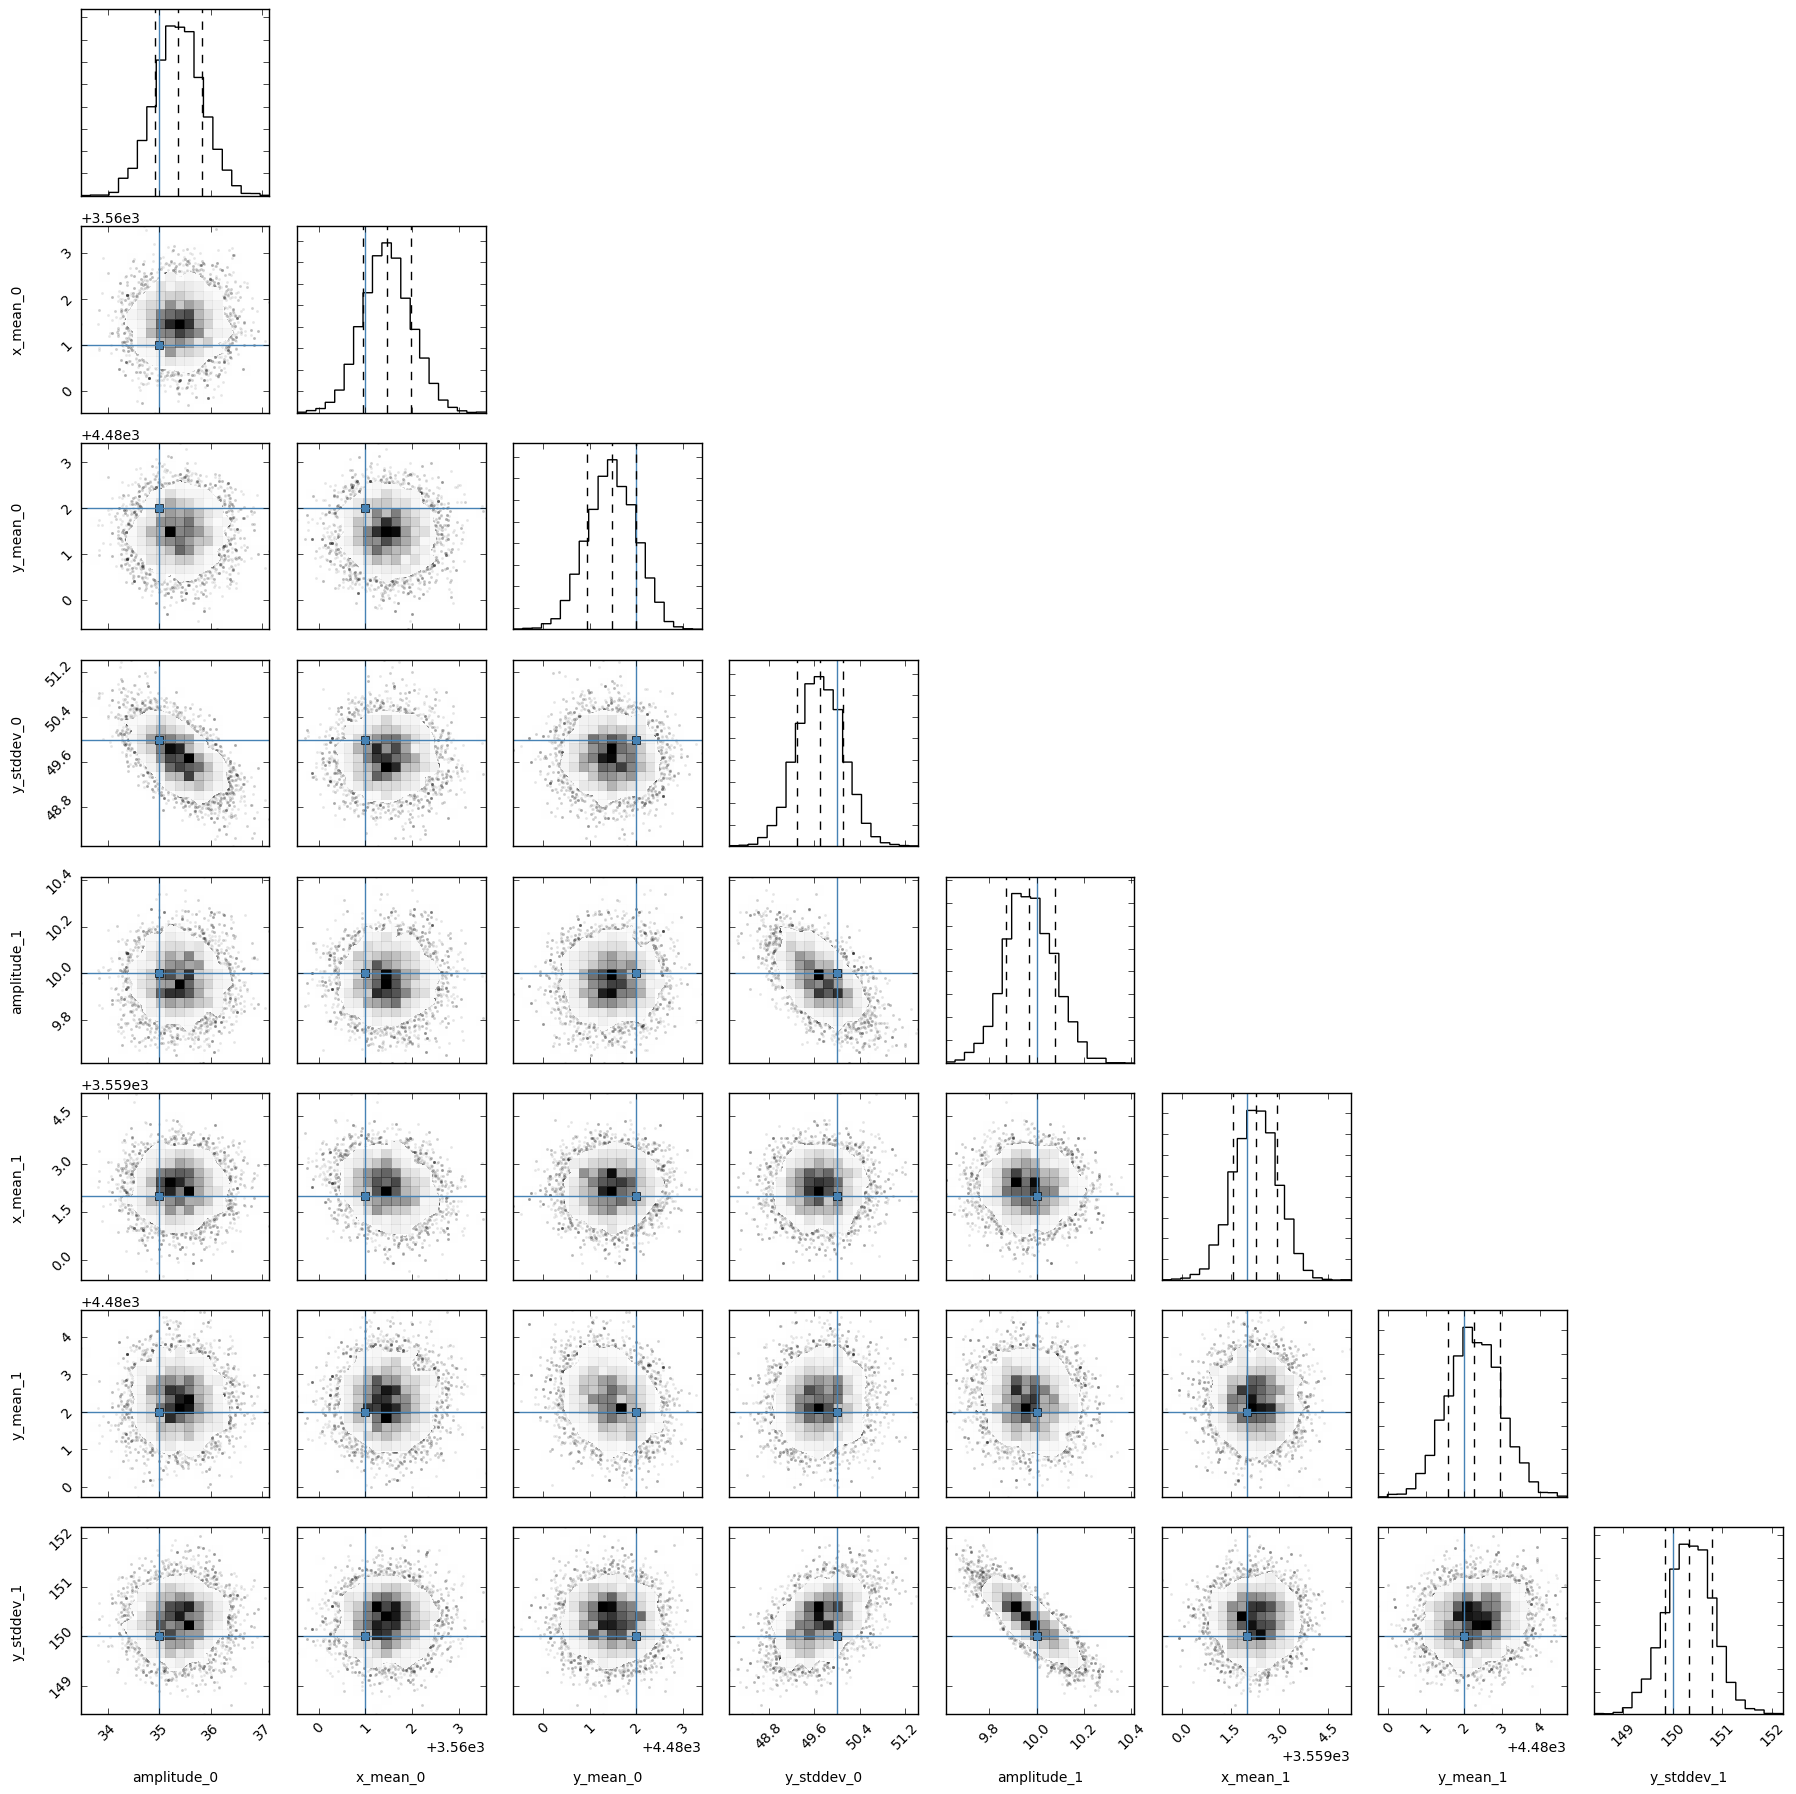

In [17]:
corner.corner(params[:,burnin:].T, labels=parnames, quantiles=[0.16, 0.5, 0.84], plot_contours=False, truths=parvals)
plt.tight_layout()

The blue lines and dots in the plot above show the true parameter values that we used to simulate the image. The true values are all in included in the 1$\sigma$ interval (~68% confidence), assuming the probability distributions are normal.